Muhammed Enes Ugras

Nurten Ciftcioglu

### Steam Game Price Prediction - Split and Preprocessing


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Local
# this csv created after 01_presplit_cleaning_eda.ipynb
#df = pd.read_csv('cleaned_presplit_games_data.csv', parse_dates=['Release date'])

# Colab + Drive, provide your path
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/Colab Notebooks/ml/ml_project_dataset/cleaned_presplit_games_data.csv"

df = pd.read_csv(file_path, parse_dates=['Release date'])

df.shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(81298, 17)

### 5. Train/Test Split

We use a time-based split, training on older games and testing on newer games. This simulates the real-world scenario where we predict prices for upcoming releases based on historical data. We find the release date cutoff that gives approximately 80% of games in Train and 20% in Test. The Test set is held out until final evaluation. During model tuning, we use TimeSeriesSplit cross-validation within Train to maintain temporal integrity.

In [ ]:
# Finding cutoff date for 80/20 time-based split
df_sorted = df.sort_values('Release date')
cutoff_idx = int(len(df_sorted) * 0.80)
cutoff_date = df_sorted.iloc[cutoff_idx]['Release date']

pd.DataFrame({
    'Metric': ['Cutoff Date', 'Train (before)', 'Test (on/after)', 'Train %'],
    'Value': [
        str(cutoff_date.date()),
        (df['Release date'] < cutoff_date).sum(),
        (df['Release date'] >= cutoff_date).sum(),
        f"{(df['Release date'] < cutoff_date).sum() / len(df) * 100:.1f}%"
    ]
})

,Metric,Value
0,Cutoff Date,2023-12-12
1,Train (before),65016
2,Test (on/after),16282
3,Train %,80.0%


In [ ]:
# Executing time-based split
train_df = df[df['Release date'] < cutoff_date].copy()
test_df = df[df['Release date'] >= cutoff_date].copy()

pd.DataFrame({
    'Set': ['Train', 'Test'],
    'Count': [len(train_df), len(test_df)],
    '%': [f"{len(train_df)/len(df)*100:.1f}%", f"{len(test_df)/len(df)*100:.1f}%"]
})

,Set,Count,%
0,Train,65016,80.0%
1,Test,16282,20.0%


Time-based split complete. Train contains games released before December 12, 2023. Test contains games from December 12, 2023 onward.

In [ ]:
# Checking if there is date overlap between Train and Test
pd.DataFrame({
    'Set': ['Train max date', 'Test min date'],
    'Value': [
        str(train_df['Release date'].max().date()),
        str(test_df['Release date'].min().date()),
    ]
})

,Set,Value
0,Train max date,2023-12-11
1,Test min date,2023-12-12


### 6. EDA on Train

Now we explore the Train set to understand distributions, relationships, and decide on transformations.

In [ ]:
# Descriptive statistics for numeric features
train_df.describe().round(2)

,Release date,Required age,Price,supported_lang_count,audio_lang_count,description_length
count,65016,65016.00,65016.00,65016.00,65016.00,65016.00
mean,2020-01-23 23:29:56.677740800,0.34,8.86,3.59,1.01,210.25
min,1997-06-30 00:00:00,0.00,0.29,0.00,0.00,0.00
25%,2018-04-06 00:00:00,0.00,2.99,1.00,0.00,109.00
50%,2020-08-31 00:00:00,0.00,5.39,1.00,0.00,171.00
75%,2022-04-29 00:00:00,0.00,9.99,4.00,1.00,265.00
max,2023-12-11 00:00:00,21.00,199.99,103.00,103.00,4355.00
std,NaN,2.36,10.85,5.32,3.18,160.94


#### Numeric histograms

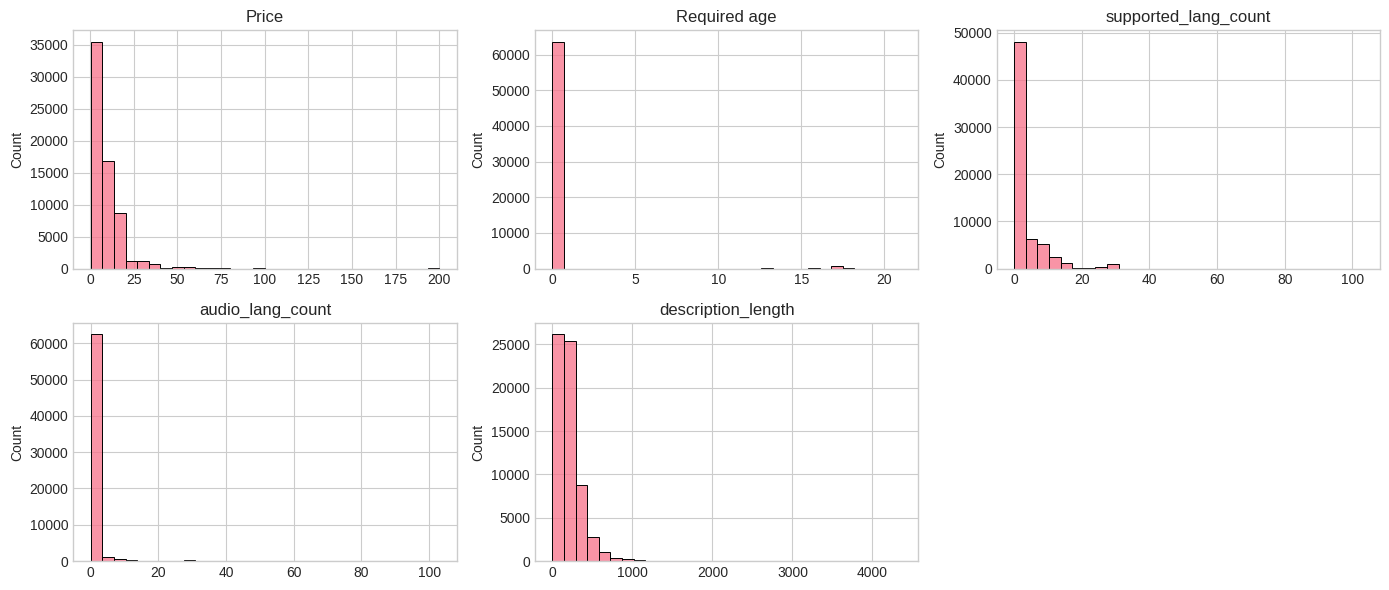

In [ ]:
# Numeric features distributions
numeric_cols = ['Price', 'Required age', 'supported_lang_count', 'audio_lang_count', 'description_length']

fig, axes = plt.subplots(2, 3, figsize=(14, 6))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    sns.histplot(train_df[col], bins=30, ax=axes[i], edgecolor='black',)
    axes[i].set_title(col)
    axes[i].set_xlabel('')
axes[5].axis('off')
plt.tight_layout()
plt.show()

All numeric features are heavily right-skewed with most values concentrated at the low end. Price, language counts, and description length all have extreme outliers creating long tails. Required age is almost entirely 0. These severe distribution patterns suggest log or power transforms may be beneficial for modeling. Transformations like log scaling may help normalize these distributions for better model performance.

#### Categorical summary

In [ ]:
# Categorical features: value counts and cardinality
cat_cols = ['Categories', 'Genres', 'Tags']

cat_summary = []
for col in cat_cols:
    non_null = train_df[col].notna().sum()
    null_pct = train_df[col].isna().sum() / len(train_df) * 100
    unique_count = train_df[col].dropna().nunique()
    cat_summary.append({
        'Column': col,
        'Non-null': non_null,
        'Missing %': f"{null_pct:.1f}%",
        'Unique values': unique_count
    })

pd.DataFrame(cat_summary)

,Column,Non-null,Missing %,Unique values
0,Categories,64261,1.2%,4548
1,Genres,64962,0.1%,1625
2,Tags,55960,13.9%,50184


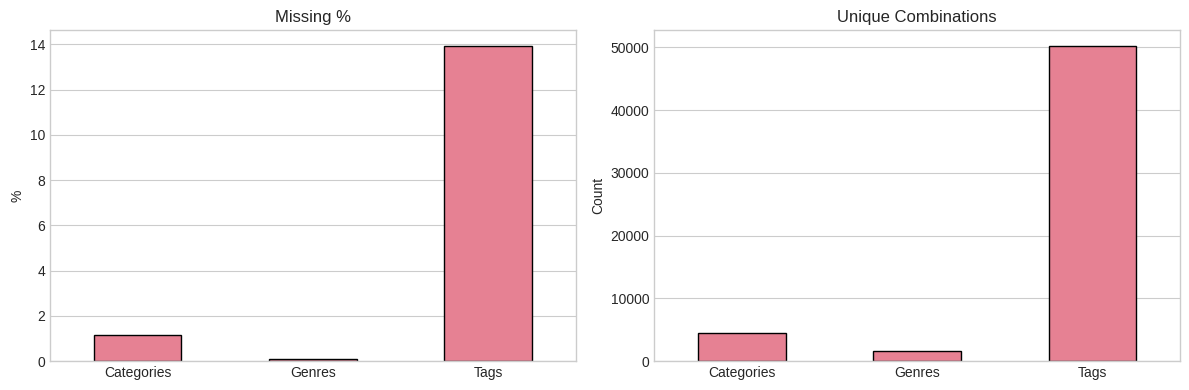

In [ ]:
# Categorical features - missing and unique value counts
cat_cols = ['Categories', 'Genres', 'Tags']
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Missing values
missing_pct = [train_df[col].isna().sum() / len(train_df) * 100 for col in cat_cols]
sns.barplot(x=cat_cols, y=missing_pct, ax=axes[0],width=0.5, edgecolor='black')
axes[0].set_title('Missing %')
axes[0].set_ylabel('%')

# Unique values
unique_counts = [train_df[col].dropna().nunique() for col in cat_cols]
sns.barplot(x=cat_cols, y=unique_counts, ax=axes[1], width=0.5, edgecolor='black')
axes[1].set_title('Unique Combinations')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

Tags has high missing rate and extreme cardinality. Genres and Categories have lower missing rates but still high cardinality. Multi-hot encoding will create sparse matrices; we may need dimensionality reduction or top-N filtering.

####  Boolean summary

In [ ]:
bool_cols = ['Windows', 'Mac', 'Linux', 'is_early_access', 'is_self_published',
             'has_audio', 'has_english_lang_support', 'has_english_audio']

bool_summary = pd.DataFrame({
    'True': train_df[bool_cols].sum(),
    'True %': (train_df[bool_cols].sum() / len(train_df) * 100).round(1)
})
bool_summary

,True,True %
Windows,64994,100.0
Mac,13342,20.5
Linux,9341,14.4
is_early_access,7854,12.1
is_self_published,48284,74.3
has_audio,27785,42.7
has_english_lang_support,62623,96.3
has_english_audio,25208,38.8


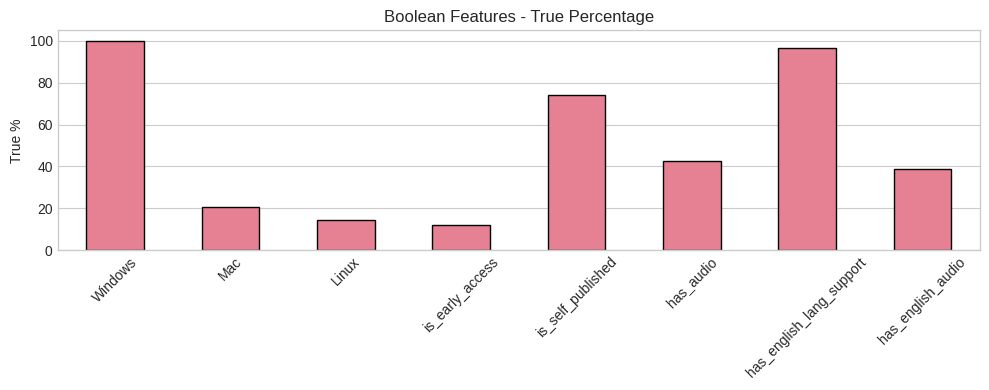

In [ ]:
# Boolean features distribution
bool_cols = ['Windows', 'Mac', 'Linux', 'is_early_access', 'is_self_published',
             'has_audio', 'has_english_lang_support', 'has_english_audio']

true_pct = (train_df[bool_cols].sum() / len(train_df) * 100)

fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x=true_pct.index, y=true_pct.values, ax=ax, width=0.5, edgecolor='black')
ax.set_xlabel('')
ax.set_ylabel('True %')
ax.set_title('Boolean Features - True Percentage')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

Windows and English language support are near-universal, making them uninformative for prediction. Most games are self-published. Mac, Linux, and Early Access show more variation and may be useful predictors. Audio localization features have moderate True rates.

#### Release Date

In [ ]:
pd.DataFrame({
    'Metric': ['Min', 'Max', 'Median'],
    'Value': [
        train_df['Release date'].min().date(),
        train_df['Release date'].max().date(),
        train_df['Release date'].median().date()
    ]
})

,Metric,Value
0,Min,1997-06-30
1,Max,2023-12-11
2,Median,2020-08-31


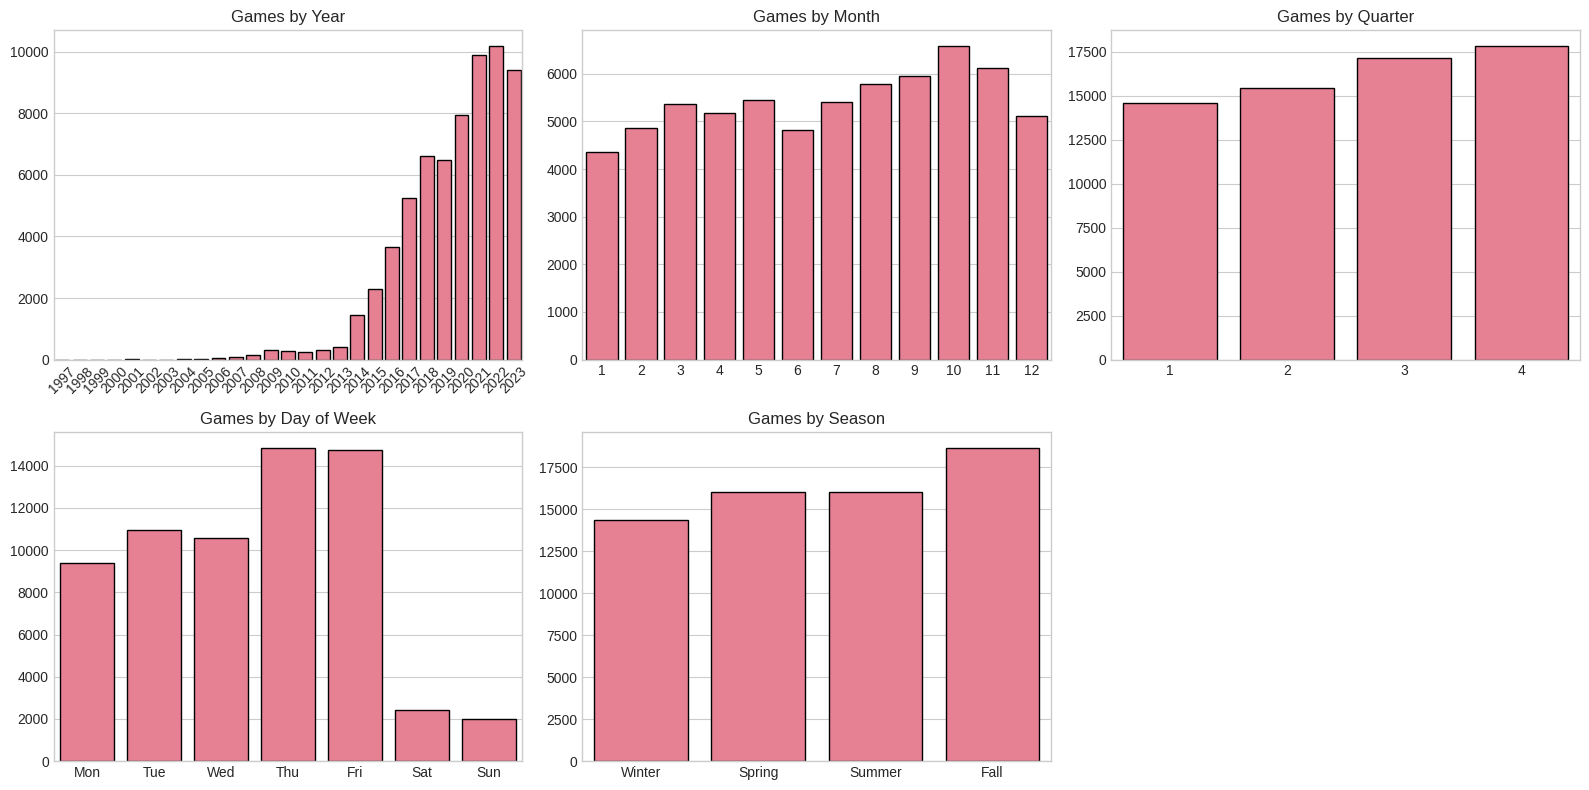

train_df columns: 17 (unchanged)


In [ ]:
#### Release Date Analysis (Visualization Only - No Permanent Changes)

# Extract to temporary Series (NOT added to train_df)
release_year = train_df['Release date'].dt.year
release_month = train_df['Release date'].dt.month
release_quarter = train_df['Release date'].dt.quarter
release_dayofweek = train_df['Release date'].dt.dayofweek
release_season = release_month.map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})

fig, axes = plt.subplots(2, 3, figsize=(16, 8))

# Year distribution
year_counts = release_year.value_counts().sort_index()
sns.barplot(x=year_counts.index, y=year_counts.values, ax=axes[0, 0], edgecolor='black')
axes[0, 0].set_title('Games by Year')
axes[0, 0].set_xlabel('')
axes[0, 0].tick_params(axis='x', rotation=45)

# Month distribution
month_counts = release_month.value_counts().sort_index()
sns.barplot(x=month_counts.index, y=month_counts.values, ax=axes[0, 1], edgecolor='black')
axes[0, 1].set_title('Games by Month')
axes[0, 1].set_xlabel('')

# Quarter distribution
quarter_counts = release_quarter.value_counts().sort_index()
sns.barplot(x=quarter_counts.index, y=quarter_counts.values, ax=axes[0, 2], edgecolor='black')
axes[0, 2].set_title('Games by Quarter')
axes[0, 2].set_xlabel('')

# Day of week distribution
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
dow_counts = release_dayofweek.value_counts().sort_index()
sns.barplot(x=dow_labels, y=dow_counts.values, ax=axes[1, 0], edgecolor='black')
axes[1, 0].set_title('Games by Day of Week')
axes[1, 0].set_xlabel('')

# Season distribution
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
season_counts = release_season.value_counts().reindex(season_order)
sns.barplot(x=season_order, y=season_counts.values, ax=axes[1, 1], edgecolor='black')
axes[1, 1].set_title('Games by Season')
axes[1, 1].set_xlabel('')

# Turn off last empty subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Confirm no columns were added
print(f"train_df columns: {len(train_df.columns)} (unchanged)")

The number of game releases has grown massively since 2015, reaching a peak around 2021 and 2022. Releases are spread evenly throughout the year across all seasons and months, with just a small drop in winter. Games are mostly released on weekdays, especially Thursdays, with very few releases on weekends.

#### Price distribution (original vs log)

Since Price is right-skewed, we compare the original distribution to a log-transformed version. Log transformation can help normalize the distribution, which may improve model performance.

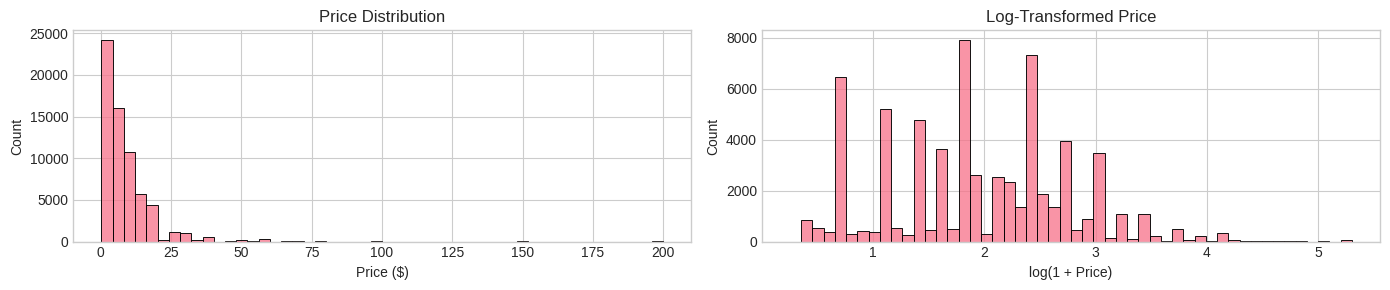

In [ ]:
# Price distribution comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 3))
sns.histplot(train_df['Price'], bins=50, ax=axes[0], edgecolor='black')
axes[0].set_xlabel('Price ($)')
axes[0].set_title('Price Distribution')
sns.histplot(np.log1p(train_df['Price']), bins=50, ax=axes[1], edgecolor='black')
axes[1].set_xlabel('log(1 + Price)')
axes[1].set_title('Log-Transformed Price')
plt.tight_layout()
plt.show()

The original Price shows strong right-skew with most games priced under $20. The log-transformed distribution is more symmetric. We will use log(Price) as the target for all models to normalize the distribution, then inverse-transform predictions to compute final metrics on the original dollar scale.

#### Correlation Analysis

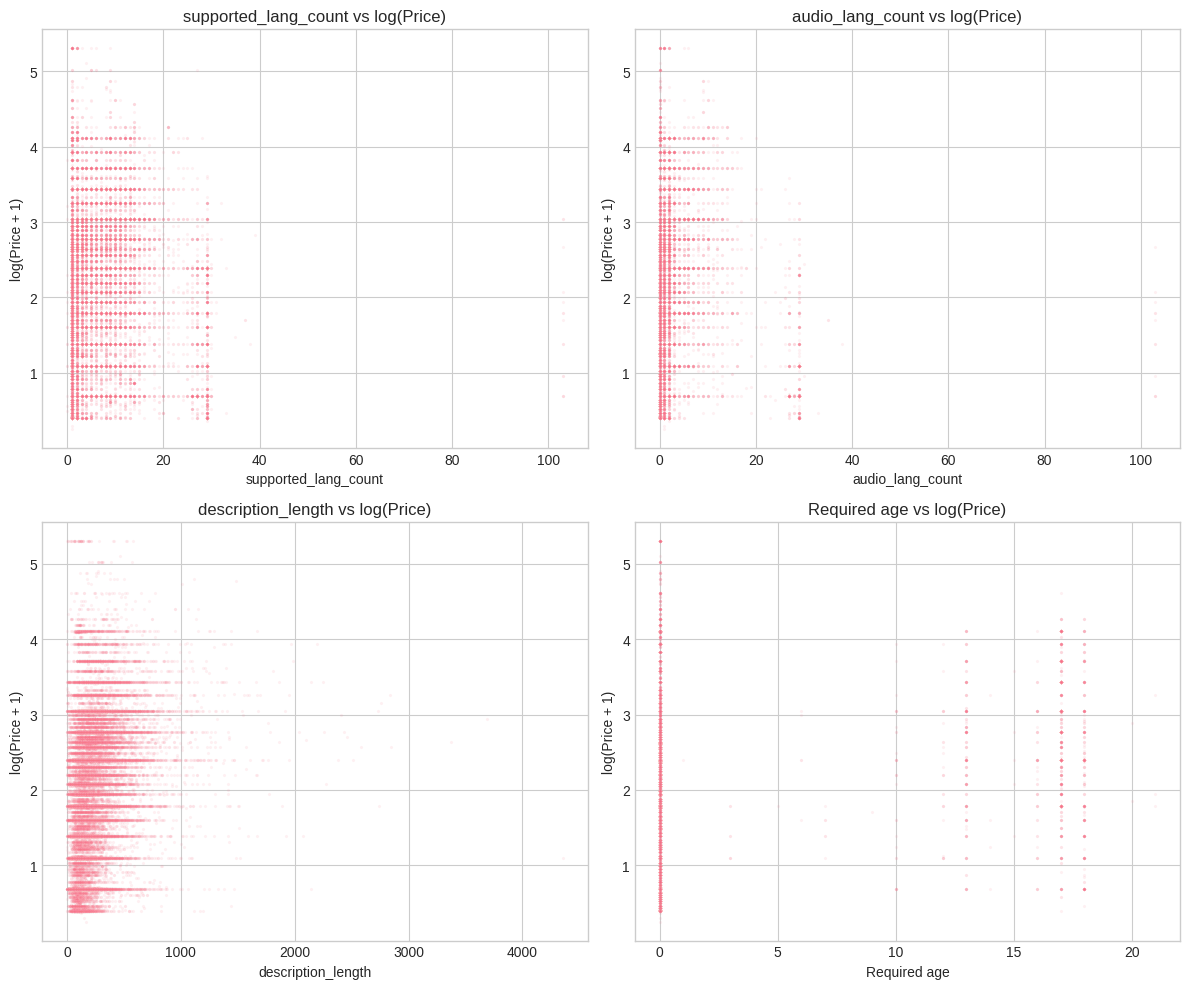

,Feature,Pearson r,Spearman r
2,description_length,0.300,0.359
0,supported_lang_count,0.081,0.192
1,audio_lang_count,0.018,0.170
3,Required age,0.122,0.109


In [ ]:
numeric_cols = ['supported_lang_count', 'audio_lang_count', 'description_length', 'Required age']

train_df_viz = train_df.copy()
train_df_viz['log_price'] = np.log1p(train_df_viz['Price'])

# Calculate correlations
correlations = []
for col in numeric_cols:
    valid_mask = train_df_viz[col].notna()
    x = train_df_viz.loc[valid_mask, col]
    y = train_df_viz.loc[valid_mask, 'log_price']

    pearson_r, _ = pearsonr(x, y)
    spearman_r, _ = spearmanr(x, y)

    correlations.append({
        'Feature': col,
        'Pearson r': round(pearson_r, 3),
        'Spearman r': round(spearman_r, 3)
    })

corr_df = pd.DataFrame(correlations).sort_values('Spearman r', key=abs, ascending=False)

# Scatter plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.scatterplot(data=train_df_viz, x=col, y='log_price', alpha=0.1, s=5, ax=axes[i])
    axes[i].set_title(f'{col} vs log(Price)')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('log(Price + 1)')

plt.tight_layout()
plt.show()

display(corr_df)

Description length shows the strongest relationship with price. Games with longer descriptions tend to be priced higher, likely reflecting more polished and professionally marketed titles. Required age has a weak positive relationship, with mature-rated games showing slightly higher prices. Language and audio localization counts show minimal direct correlation, though games with extensive localization often represent larger-budget productions. Overall, no single numeric feature strongly predicts price on its own, suggesting that categorical features like genres and tags will be more important for prediction.

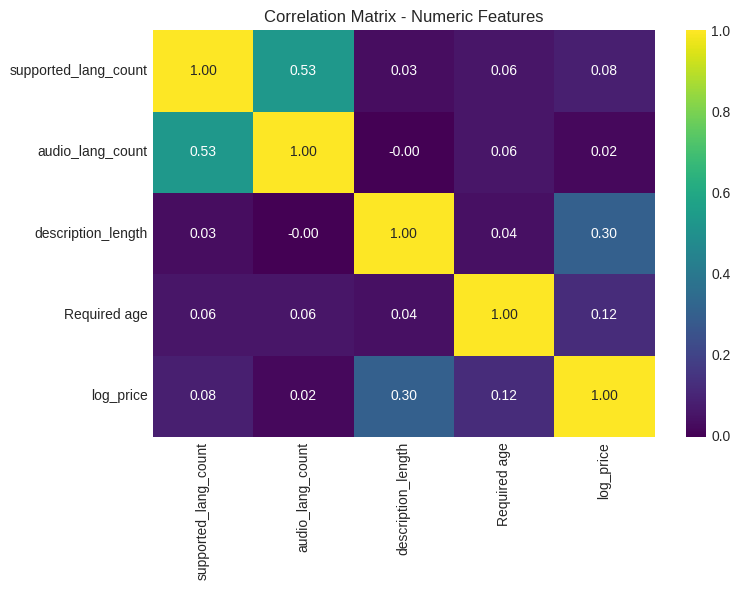

In [ ]:
##### Correlation Matrix

numeric_features = ['supported_lang_count', 'audio_lang_count', 'description_length', 'Required age']

train_df_viz = train_df[numeric_features].copy()
train_df_viz['log_price'] = np.log1p(train_df['Price'])

correlation = train_df_viz.corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='viridis', fmt='.2f', ax=ax)
ax.set_title('Correlation Matrix - Numeric Features')
plt.tight_layout()
plt.show()

The correlation matrix shows no concerning multicollinearity between features. The only notable relationship is between supported_lang_count and audio_lang_count, which is expected since games with extensive language support often include both subtitle and audio localization. All other feature pairs have weak correlations, meaning each numeric feature contributes independent information. No features need to be dropped due to redundancy.

#### Price by Top Genres

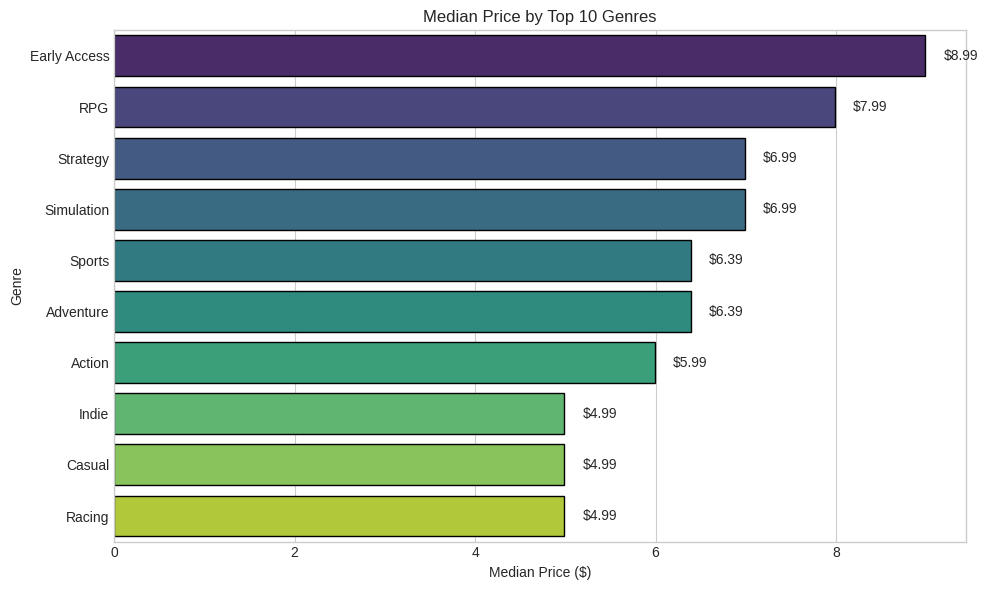

,Genre,Count,Median_Price,Mean_Price
7,Early Access,7854,8.99,10.383442
6,RPG,11260,7.99,10.469308
5,Strategy,12336,6.99,9.528083
4,Simulation,13030,6.99,10.197277
8,Sports,2999,6.39,10.231224
3,Adventure,25667,6.39,9.076195
2,Action,27128,5.99,8.775836
0,Indie,46377,4.99,7.406362
1,Casual,27530,4.99,6.386025
9,Racing,2504,4.99,8.969285


In [ ]:
all_genres = train_df['Genres'].dropna().str.split(',').explode().str.strip()
top_genres = all_genres.value_counts().head(10).index.tolist()

# Calculate median price for each top genre
genre_stats = []
for genre in top_genres:
    mask = train_df['Genres'].fillna('').str.contains(genre, case=False, regex=False)
    prices = train_df.loc[mask, 'Price']
    genre_stats.append({
        'Genre': genre,
        'Count': mask.sum(),
        'Median_Price': prices.median(),
        'Mean_Price': prices.mean()
    })

genre_df = pd.DataFrame(genre_stats).sort_values('Median_Price', ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='Median_Price', y='Genre', data=genre_df, ax=ax, palette='viridis', edgecolor='black')
ax.set_xlabel('Median Price ($)')
ax.set_title('Median Price by Top 10 Genres')

for i, (idx, row) in enumerate(genre_df.iterrows()):
    ax.text(row['Median_Price'] + 0.2, i, f"${row['Median_Price']:.2f}", va='center')

plt.tight_layout()
plt.show()

genre_df

Early Access and RPG games command the highest median prices, followed by Strategy and Simulation. Indie and Casual games have the lowest median prices, likely due to the abundance of small-scale, low-budget titles in these genres. This suggests genre is a meaningful predictor of price positioning.

#### Price vs Boolean Features

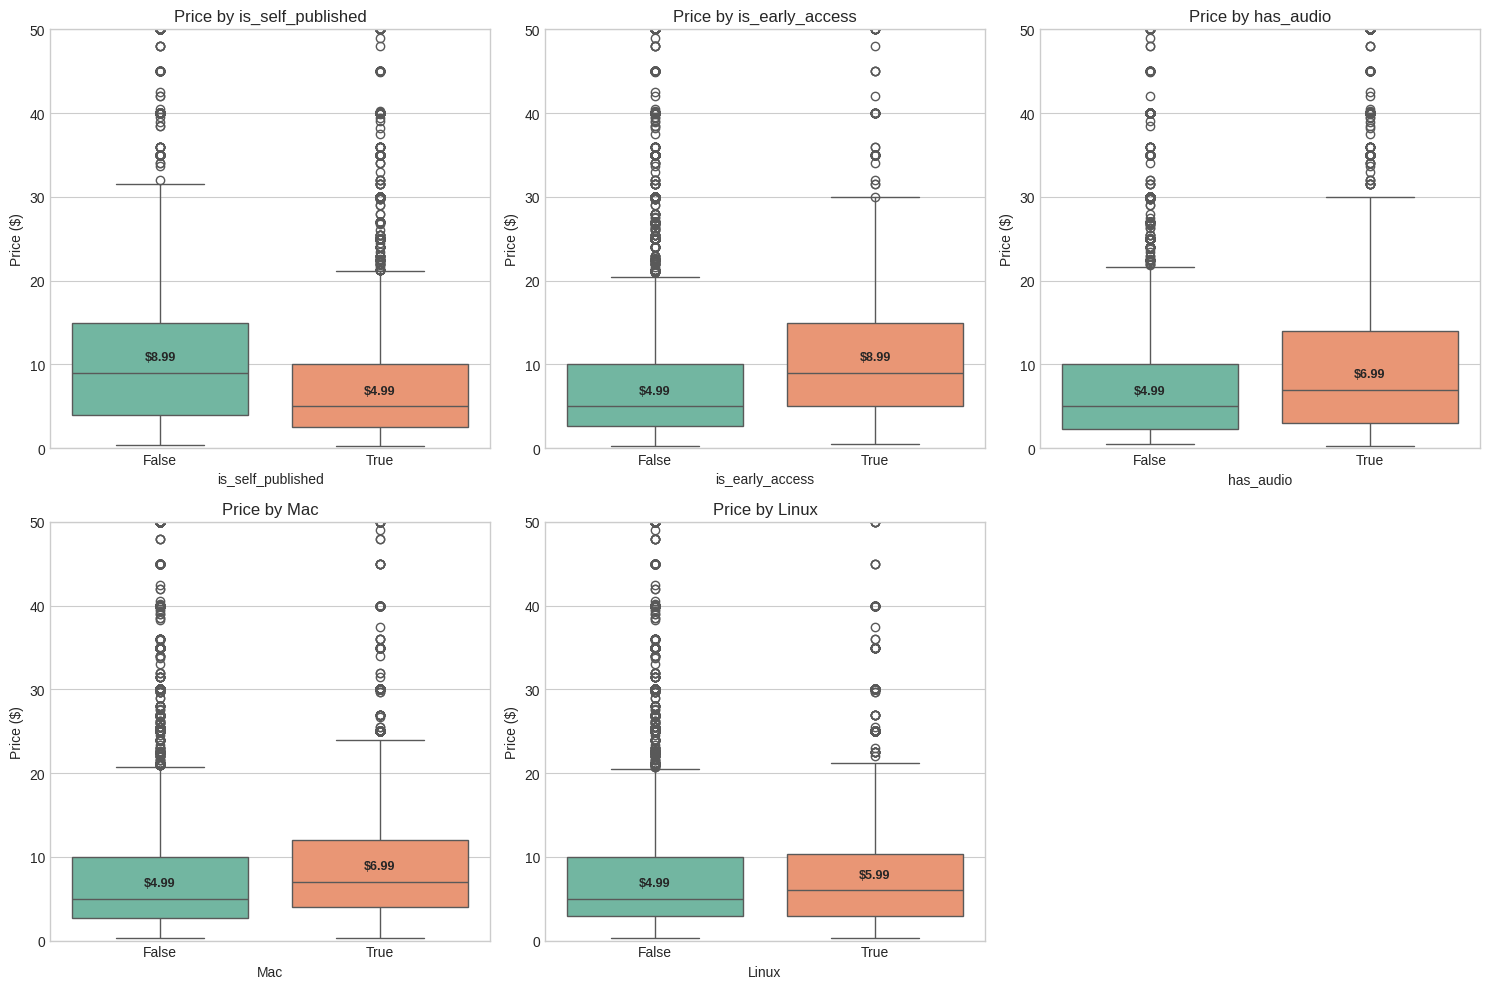

,Feature,Value,Count,Median,Mean
0,is_self_published,False,16732,8.99,11.22
1,is_self_published,True,48284,4.99,8.05
2,is_early_access,False,57162,4.99,8.66
3,is_early_access,True,7854,8.99,10.38
4,has_audio,False,37231,4.99,7.76
5,has_audio,True,27785,6.99,10.34
6,Mac,False,51674,4.99,8.84
7,Mac,True,13342,6.99,8.97
8,Linux,False,55675,4.99,8.92
9,Linux,True,9341,5.99,8.53


In [ ]:
bool_features = ['is_self_published', 'is_early_access', 'has_audio', 'Mac', 'Linux']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(bool_features):
    ax = axes[i]
    sns.boxplot(x=train_df[col], y=train_df['Price'], ax=ax, palette='Set2')
    ax.set_title(f'Price by {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Price ($)')
    ax.set_ylim(0, 50)  # Focus on main distribution

    # Add median annotations
    medians = train_df.groupby(col)['Price'].median()
    for j, (val, med) in enumerate(medians.items()):
        ax.text(j, med + 1.5, f'${med:.2f}', ha='center', fontsize=9, fontweight='bold')

axes[5].axis('off')
plt.tight_layout()
plt.show()

# Summary statistics table
bool_summary = []
for col in bool_features:
    for val in [False, True]:
        subset = train_df[train_df[col] == val]['Price']
        bool_summary.append({
            'Feature': col,
            'Value': val,
            'Count': len(subset),
            'Median': subset.median(),
            'Mean': round(subset.mean(), 2)
        })

pd.DataFrame(bool_summary)

- Self-published games have lower median prices compared to publisher-backed games, suggesting publishers tend to price higher or target premium segments.

- Early Access games have higher median prices, possibly because developers set aspirational prices before full release.

- Audio localization ***has_audio*** correlates with higher prices, games with audio support tend to be more polished/larger productions.

- Mac/Linux support shows higher median prices, likely because multi-platform releases require more development investment and signal higher production quality.

#### Price by Platform Combination


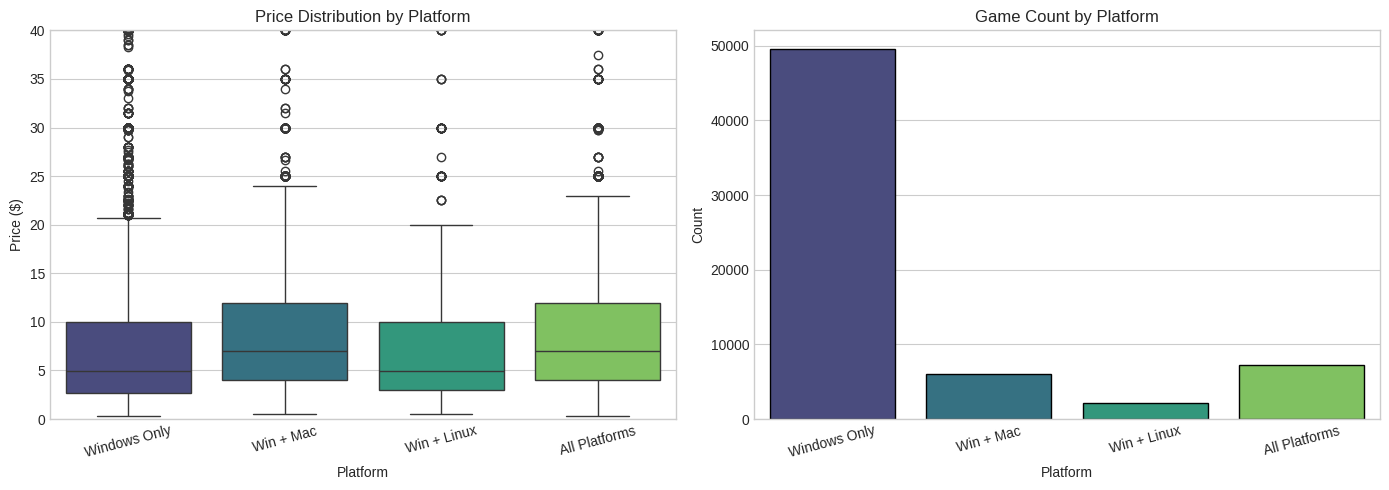

,Count,Median Price,Mean Price
Platform,,,
Windows Only,49583,4.99,8.91
Win + Mac,6074,6.99,8.98
Win + Linux,2088,4.99,7.19
All Platforms,7249,6.99,8.92


In [ ]:
platform_combo = (train_df['Windows'].astype(str) + '_' +
                  train_df['Mac'].astype(str) + '_' +
                  train_df['Linux'].astype(str))

platform_map = {
    'True_False_False': 'Windows Only',
    'True_True_False': 'Win + Mac',
    'True_False_True': 'Win + Linux',
    'True_True_True': 'All Platforms'
}
platform_readable = platform_combo.map(lambda x: platform_map.get(x, 'Other'))

plot_df = pd.DataFrame({
    'Platform': platform_readable,
    'Price': train_df['Price']
})

main_platforms = ['Windows Only', 'Win + Mac', 'Win + Linux', 'All Platforms']
plot_df = plot_df[plot_df['Platform'].isin(main_platforms)]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
order = ['Windows Only', 'Win + Mac', 'Win + Linux', 'All Platforms']
sns.boxplot(x='Platform', y='Price', data=plot_df, ax=axes[0], order=order, palette='viridis')
axes[0].set_title('Price Distribution by Platform')
axes[0].set_ylabel('Price ($)')
axes[0].set_ylim(0, 40)
axes[0].tick_params(axis='x', rotation=15)

# Bar chart of counts
platform_counts = plot_df['Platform'].value_counts().reindex(order)
sns.barplot(x=platform_counts.index, y=platform_counts.values, ax=axes[1], palette='viridis', edgecolor='black')
axes[1].set_title('Game Count by Platform')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

platform_stats = plot_df.groupby('Platform')['Price'].agg(['count', 'median', 'mean']).round(2)
platform_stats = platform_stats.reindex(order)
platform_stats.columns = ['Count', 'Median Price', 'Mean Price']
platform_stats

Windows-only games dominate the market but have the lowest median price. Games supporting all platforms have the highest median price, followed by Win+Mac. This pattern makes sense: multi-platform releases typically come from more established studios with larger budgets and higher production values. The platform combination could be a useful feature, though the individual boolean flags already capture this information.

#### Price Trends by Release Year

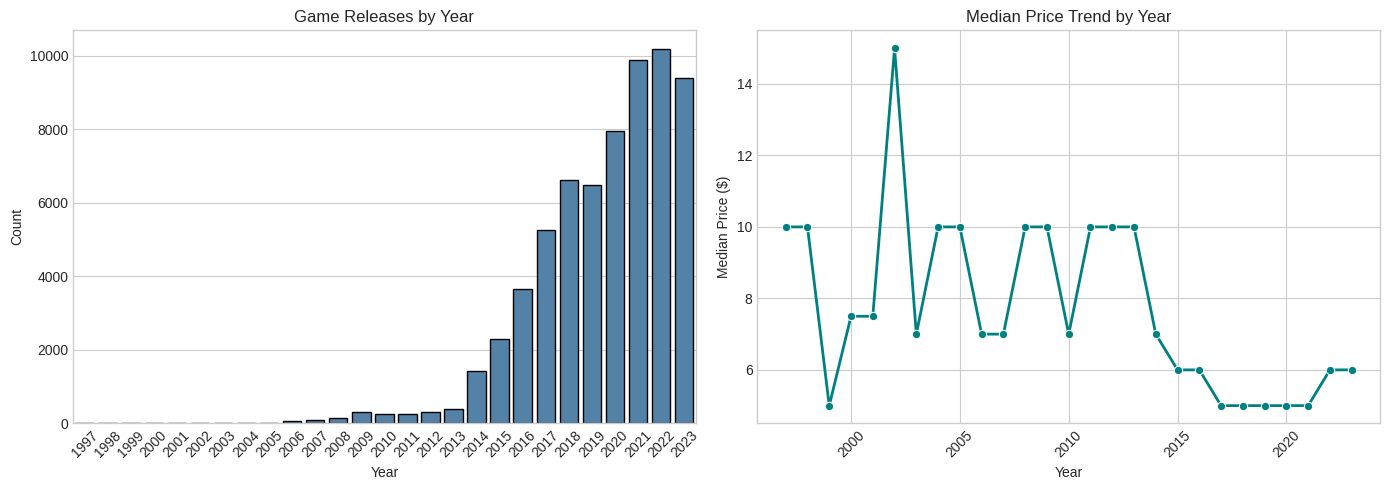

,release_year,Count,Median_Price,Mean_Price
0,1997,1,9.99,9.990000
1,1998,1,9.99,9.990000
2,1999,2,4.99,4.990000
3,2000,2,7.49,7.490000
4,2001,4,7.49,9.990000
5,2002,1,14.99,14.990000
6,2003,3,6.99,10.656667
7,2004,7,9.99,9.990000
8,2005,6,9.99,9.656667
9,2006,62,6.99,9.891613


In [ ]:
release_year = train_df['Release date'].dt.year

yearly_data = train_df.copy()
yearly_data['release_year'] = release_year
yearly_stats = yearly_data[yearly_data['release_year'] >= 1997].groupby('release_year').agg(
    Count=('Price', 'count'),
    Median_Price=('Price', 'median'),
    Mean_Price=('Price', 'mean')
).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(x='release_year', y='Count', data=yearly_stats, ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title('Game Releases by Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

sns.lineplot(x='release_year', y='Median_Price', data=yearly_stats, ax=axes[1], marker='o', linewidth=2, color='teal')
axes[1].set_title('Median Price Trend by Year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Median Price ($)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

yearly_stats

Game releases were nearly zero before 2006 and stayed under 500 per year until 2012. Growth accelerated from 2013 onwards, jumping from ~1,500 to over 10,000 by 2020. Releases peaked around 2020-2021 and slightly dropped in 2022-2023.

The median price chart shows wild fluctuations before 2010, swinging between \$5 and \$15. This instability comes from small sample sizes when only a handful of games exist in a year, the median is unreliable. From around 2014 onwards, where we have thousands of games per year, the median price settles into a stable \$5-6 range and stays there despite the massive increase in releases.

#### Imbalance Analysis

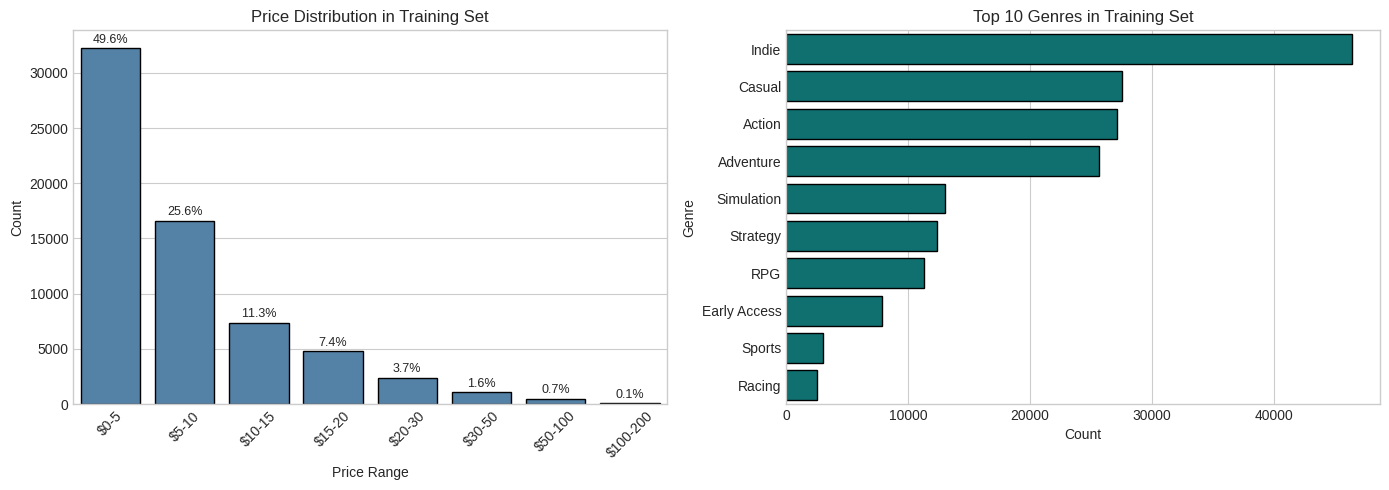

In [ ]:
price_bins = [0, 5, 10, 15, 20, 30, 50, 100, 200]
price_labels = ['$0-5', '$5-10', '$10-15', '$15-20', '$20-30', '$30-50', '$50-100', '$100-200']
train_df_temp = train_df.copy()
train_df_temp['price_bucket'] = pd.cut(train_df_temp['Price'], bins=price_bins, labels=price_labels, right=False)
price_dist = train_df_temp['price_bucket'].value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
sns.barplot(x=price_dist.index.astype(str), y=price_dist.values, ax=ax, color='steelblue', edgecolor='black')
ax.set_title('Price Distribution in Training Set')
ax.set_xlabel('Price Range')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=45)

total = len(train_df)
for i, v in enumerate(price_dist):
    ax.text(i, v + 500, f'{100*v/total:.1f}%', ha='center', fontsize=9)

ax2 = axes[1]
genre_counts = train_df['Genres'].dropna().str.split(',').explode().str.strip().value_counts().head(10)
genre_df_imb = pd.DataFrame({'Genre': genre_counts.index, 'Count': genre_counts.values})
sns.barplot(x='Count', y='Genre', data=genre_df_imb, ax=ax2, color='teal', edgecolor='black')
ax2.set_title('Top 10 Genres in Training Set')
ax2.set_xlabel('Count')

plt.tight_layout()
plt.show()

The price distribution is heavily imbalanced 75% of games are priced under \$10, and 94% under \$20. This concentration in the low-price range means our model will be trained primarily on cheap games, potentially struggling with the sparse high-price segment. Genre distribution shows Indie dominates, followed by Action and Casual. This imbalance suggests we should evaluate model performance separately across price tiers and consider whether stratified sampling or weighted loss could help.

### 7. Outlier Detection


We analyze outliers on log-transformed price since that's our modeling target. IQR method on log scale identifies prices that are statistically extreme relative to the distribution. We already capped at $200 in Phase 4, but there may still be outliers within that range.

In [ ]:
log_price = np.log1p(train_df['Price'])

Q1, Q3 = log_price.quantile([0.25, 0.75])
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

lower_price = np.expm1(lower_bound)
upper_price = np.expm1(upper_bound)

low_outliers = (log_price < lower_bound).sum()
high_outliers = (log_price > upper_bound).sum()

pd.DataFrame({
    'Metric': ['Q1 (log)', 'Q3 (log)', 'IQR', 'Lower Bound (log)', 'Upper Bound (log)',
               'Lower Bound ($)', 'Upper Bound ($)', 'Low Outliers', 'High Outliers', 'Total Outliers'],
    'Value': [f'{Q1:.3f}', f'{Q3:.3f}', f'{IQR:.3f}', f'{lower_bound:.3f}', f'{upper_bound:.3f}',
              f'${lower_price:.2f}', f'${upper_price:.2f}', low_outliers, high_outliers, low_outliers + high_outliers]
}).set_index('Metric')

,Value
Metric,
Q1 (log),1.384
Q3 (log),2.397
IQR,1.013
Lower Bound (log),-0.136
Upper Bound (log),3.917
Lower Bound ($),$-0.13
Upper Bound ($),$49.24
Low Outliers,0
High Outliers,781


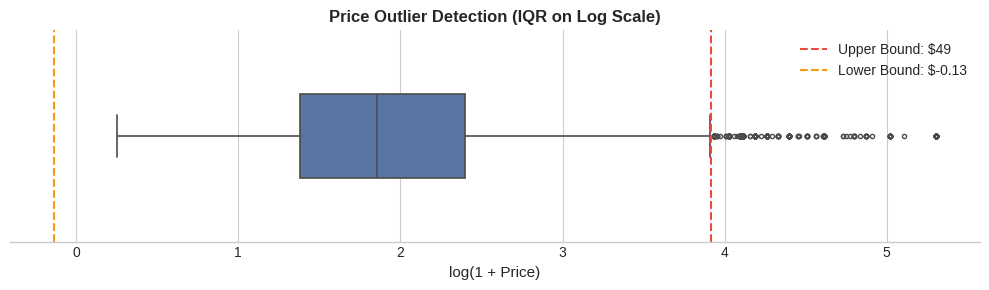

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))
sns.boxplot(x=log_price, ax=ax, color='#4C72B0', width=0.4, fliersize=3, linewidth=1.2)
ax.axvline(upper_bound, color='#E74C3C', linestyle='--', linewidth=1.5, label=f'Upper Bound: ${upper_price:.0f}')
ax.axvline(lower_bound, color='#F39C12', linestyle='--', linewidth=1.5, label=f'Lower Bound: ${lower_price:.2f}')
ax.set_xlabel('log(1 + Price)', fontsize=11)
ax.set_title('Price Outlier Detection (IQR on Log Scale)', fontsize=12, fontweight='bold')
ax.legend(loc='upper right', framealpha=0.9)
ax.set_yticks([])
sns.despine(left=True)
plt.tight_layout()
plt.show()

 The IQR method on log-transformed price identifies \$49 as the upper bound, meaning games priced above this are statistically rare in our dataset. The lower bound is negative, so no lower outliers exist since our minimum price is around \$0.49.
We decide to keep all prices without additional treatment. The reason is that statistical rarity does not mean invalid data. In the gaming industry, \$60 is the standard AAA price point and \$40-50 is common for mid-tier releases. The IQR method flags these as outliers simply because our dataset is dominated by cheap indie games, not because these prices are errors or anomalies.
We already applied a domain-based cap at \$200, removing collector's editions, joke prices, and ultra-niche simulators. The remaining games in the \$49-200 range represent legitimate premium pricing that our model should learn to predict.
Additionally, the log transform we're using for modeling already compresses the price scale and reduces the influence of high values. Tree-based models like RandomForest and XGBoost, which are our primary candidates, handle such variation naturally without requiring explicit outlier treatment.

In [ ]:
numeric_cols = ['Required age', 'supported_lang_count', 'audio_lang_count', 'description_length']

summary = pd.DataFrame({
    'Min': train_df[numeric_cols].min(),
    'Q1': train_df[numeric_cols].quantile(0.25),
    'Median': train_df[numeric_cols].median(),
    'Q3': train_df[numeric_cols].quantile(0.75),
    'Max': train_df[numeric_cols].max(),
    'Zeros': (train_df[numeric_cols] == 0).sum()
})

desc = train_df['description_length']
Q1, Q3 = desc.quantile([0.25, 0.75])
IQR = Q3 - Q1
summary.loc['description_length', 'IQR_Upper'] = Q3 + 1.5 * IQR
summary.loc['description_length', 'High_Outliers'] = (desc > Q3 + 1.5 * IQR).sum()

summary.round(1)

,Min,Q1,Median,Q3,Max,Zeros,IQR_Upper,High_Outliers
Required age,0,0.0,0.0,0.0,21,63638,NaN,NaN
supported_lang_count,0,1.0,1.0,4.0,103,16,NaN,NaN
audio_lang_count,0,0.0,0.0,1.0,103,37231,NaN,NaN
description_length,0,109.0,171.0,265.0,4355,62,499.0,3041.0


Required age is almost entirely zeros 98% of games have no age restriction. The remaining 2% use discrete rating values, not a continuous scale. There's no meaningful outlier concept here since these are standardized rating categories.

Language counts show typical indie game patterns. Most games support just one language, with Q1=1 for supported languages. Audio support is even sparser most games have zero audio languages. However, the max of 103 languages seems implausibly high and warrants investigation.

Description length has the widest spread. The median is 171 words, but games range from 0 to 4,355 words. The IQR method flags 3,041 games above 499 words as statistical outliers. However, longer descriptions simply reflect more detailed store pages and often a sign of polish and marketing effort. These are valid signals, not data quality issues.

In [ ]:
# Checking games with extreme language counts
high_lang = train_df[train_df['supported_lang_count'] > 30][
    ['supported_lang_count', 'audio_lang_count', 'Price']
].sort_values('supported_lang_count', ascending=False)

pd.DataFrame({
    'Metric': ['Games with >30 languages', 'Max supported_lang', 'Max audio_lang', '99th percentile supported', '95th percentile supported'],
    'Value': [
        len(high_lang),
        train_df['supported_lang_count'].max(),
        train_df['audio_lang_count'].max(),
        train_df['supported_lang_count'].quantile(0.99),
        train_df['supported_lang_count'].quantile(0.95)
    ]
})

,Metric,Value
0,Games with >30 languages,26.0
1,Max supported_lang,103.0
2,Max audio_lang,103.0
3,99th percentile supported,29.0
4,95th percentile supported,13.0


Capped both language count features at their 99th percentile. Values above 29 languages affected only 26 games and likely represent parsing artifacts rather than real localization. This preserves the meaningful variation while removing implausible extremes.

In [ ]:
lang_cap_supported = train_df['supported_lang_count'].quantile(0.99)  # 29
lang_cap_audio = train_df['audio_lang_count'].quantile(0.99)

train_df['supported_lang_count'] = train_df['supported_lang_count'].clip(upper=lang_cap_supported)
train_df['audio_lang_count'] = train_df['audio_lang_count'].clip(upper=lang_cap_audio)

pd.DataFrame({
    'Feature': ['supported_lang_count', 'audio_lang_count'],
    'Cap Applied': [lang_cap_supported, lang_cap_audio],
    'New Max': [train_df['supported_lang_count'].max(), train_df['audio_lang_count'].max()]
})

,Feature,Cap Applied,New Max
0,supported_lang_count,29.0,29
1,audio_lang_count,13.0,13


### 8. Missing Values

In [ ]:
missing = train_df[['Tags', 'Categories', 'Genres']].isna().sum()
missing_pct = (missing / len(train_df) * 100).round(1)

pd.DataFrame({
    'Missing': missing,
    'Percent': missing_pct.astype(str) + '%'
})

,Missing,Percent
Tags,9056,13.9%
Categories,755,1.2%
Genres,54,0.1%


For multi-label categorical columns like Genres, Categories, and Tags, imputation is non-trivial. Mode imputation would assign either a full label combination, which creates artificial similarity between unrelated games, or a single label, which makes games appear single-categorized when most have five or six labels. Games without any genre look particularly awkward in a dataset where the average game has multiple.
Rather than introduce noise, we handle each column based on missingness severity. For Genres, only 0.1% of games are missing values. These 56 games are too few to impact training, and any imputation would introduce bias, so we drop them. For Categories, 1.1% are missing. This is still small enough that clean data is preferable to artificial labels, so we drop these as well.
Tags present a different situation. With 18.5% missing, dropping would remove too much data. Instead, we fill with an empty string and create a ***has_tags*** indicator feature. Missingness here may itself be predictive, since newer or less visible games often lack community tags. This approach yields a clean dataset where Genres and Categories are always real labels, while Tags missingness is explicitly captured as a signal.

In [ ]:
start_count = len(train_df)

train_df = train_df[train_df['Genres'].notna() & train_df['Categories'].notna()].copy()

train_df['has_tags'] = train_df['Tags'].notna().astype(int)
train_df['Tags'] = train_df['Tags'].fillna('')

pd.DataFrame({
    'Metric': ['Starting count', 'After dropping missing Genres/Categories', 'Rows dropped', 'has_tags=1', 'has_tags=0'],
    'Value': [
        start_count,
        len(train_df),
        start_count - len(train_df),
        train_df['has_tags'].sum(),
        (train_df['has_tags'] == 0).sum()
    ]
})

,Metric,Value
0,Starting count,65016
1,After dropping missing Genres/Categories,64213
2,Rows dropped,803
3,has_tags=1,55281
4,has_tags=0,8932


Dropped 803 games with missing Genres or Categories, leaving 64,213 games in Train. This reduction is acceptable for ensuring clean multi-label data. The ***has_tags*** indicator shows 8,932 games have no community tags. These games are typically newer releases or niche titles where the Steam community hasn't yet added descriptive tags. The indicator captures this signal explicitly, allowing the model to learn any pricing patterns associated with metadata availability.

### 9. Feature Engineering

#### Date Feature Extraction
Extract temporal features from Release date to capture when games were released:

- release_year: The year of release
- release_month: Month of release (1-12)
- release_day_of_week: Day of week (0=Monday through 6=Sunday)
- release_quarter: Quarter of the year (1-4)
- release_season: Season category (Winter, Spring, Summer, Fall)

These features help the model learn if pricing patterns vary by time period. From EDA, we know Friday is the dominant release day and there's no strong seasonal bias in this dataset."

In [ ]:
train_df['release_year'] = train_df['Release date'].dt.year
train_df['release_month'] = train_df['Release date'].dt.month
train_df['release_day_of_week'] = train_df['Release date'].dt.dayofweek
train_df['release_quarter'] = train_df['Release date'].dt.quarter

# Dec-Feb=Winter, Mar-May=Spring, Jun-Aug=Summer, Sep-Nov=Fall
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

train_df['release_season'] = train_df['release_month'].apply(get_season)

# Dropping original date column
train_df = train_df.drop(columns=['Release date'])

print("Numeric Date Features:")
display(pd.DataFrame({
    'Feature': ['release_year', 'release_month', 'release_day_of_week', 'release_quarter'],
    'Min': [train_df['release_year'].min(), train_df['release_month'].min(),
            train_df['release_day_of_week'].min(), train_df['release_quarter'].min()],
    'Max': [train_df['release_year'].max(), train_df['release_month'].max(),
            train_df['release_day_of_week'].max(), train_df['release_quarter'].max()]
}))
# Season distribution
print("\nSeason Distribution:")
train_df['release_season'].value_counts()

Numeric Date Features:


,Feature,Min,Max
0,release_year,1997,2023
1,release_month,1,12
2,release_day_of_week,0,6
3,release_quarter,1,4



Season Distribution:


,count
release_season,
Fall,18409
Summer,15821
Spring,15813
Winter,14170


Created 5 date features from Release date: release_year, release_month, release_day_of_week, release_quarter, and release_season. The original Release date column was dropped.

The numeric features (year, month, day_of_week, quarter) are ready for modeling. The release_season column is categorical with 4 values and needs to be encoded in the next step along with Genres, Categories, and Tags.

#### Price Transform (Target Variable)

Applying log1p transformation to Price, our target variable. Price has skewness of 6.29, heavily right-skewed with range from \$0.29 to \$200. The log1p(x) = log(1+x) transformation compresses the long tail. Models will predict log_price and final predictions will be inverse-transformed for evaluation on original price scale.

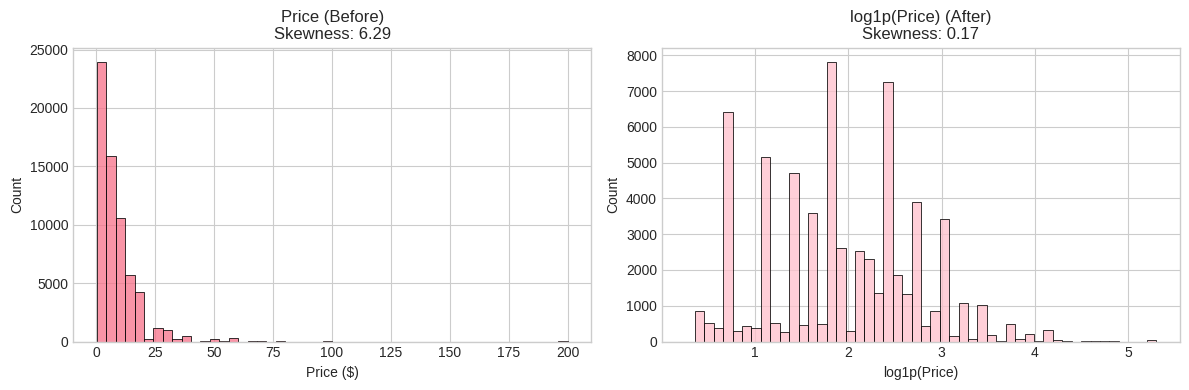

,Metric,Original Price,log_price
0,Min,0.29,0.25
1,Max,199.99,5.30
2,Mean,8.69,1.93
3,Median,5.24,1.83
4,Skewness,6.29,0.17


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Before log transform
sns.histplot(train_df['Price'], bins=50, ax=axes[0], edgecolor='black')
axes[0].set_title(f"Price (Before)\nSkewness: {train_df['Price'].skew():.2f}")
axes[0].set_xlabel('Price ($)')
axes[0].set_ylabel('Count')

train_df['log_price'] = np.log1p(train_df['Price'])

# After log transform
sns.histplot(train_df['log_price'], bins=50, ax=axes[1], edgecolor='black', color='#FFC0CB')
axes[1].set_title(f"log1p(Price) (After)\nSkewness: {train_df['log_price'].skew():.2f}")
axes[1].set_xlabel('log1p(Price)')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

temp = pd.DataFrame({
    'Metric': ['Min', 'Max', 'Mean', 'Median', 'Skewness'],
    'Original Price': [train_df['Price'].min(), train_df['Price'].max(),
                       round(train_df['Price'].mean(), 2), train_df['Price'].median(),
                       round(train_df['Price'].skew(), 2)],
    'log_price': [round(train_df['log_price'].min(), 2), round(train_df['log_price'].max(), 2),
                  round(train_df['log_price'].mean(), 2), round(train_df['log_price'].median(), 2),
                  round(train_df['log_price'].skew(), 2)]
})

train_df = train_df.drop(columns=['Price'])

temp

The log1p transformation reduced skewness from 6.29 to 0.17, making the distribution nearly symmetric. Original price ranged from \$0.29 to \$199.99 with mean \$8.69 and median \$5.24. After transformation, log_price ranges from 0.25 to 5.30 with mean 1.93 and median 1.83. The mean and median are now close, confirming the skewness is corrected. We will use log_price as the modeling target.

#### description_length Transform

description_length is right-skewed: most games have short-to-medium descriptions while some have extremely long store pages. This creates a similar issue where the model sees mostly short descriptions and struggles with the range.
The log1p transformation also captures diminishing returns: the difference between a 50-word and 150-word description signals polish, but 2000 vs 2100 words adds no meaningful information.

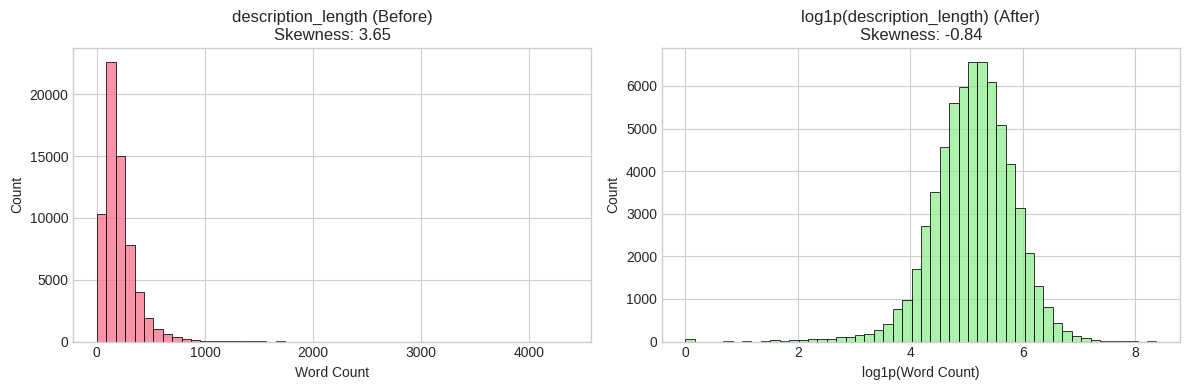

,Metric,Original,log_description_length
0,Min,0.00,0.00
1,Max,4355.00,8.38
2,Mean,209.50,5.12
3,Median,171.00,5.15
4,Skewness,3.65,-0.84


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Before log transform
sns.histplot(train_df['description_length'], bins=50, ax=axes[0], edgecolor='black')
axes[0].set_title(f"description_length (Before)\nSkewness: {train_df['description_length'].skew():.2f}")
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Count')

train_df['log_description_length'] = np.log1p(train_df['description_length'])

# After log transform
sns.histplot(train_df['log_description_length'], bins=50, ax=axes[1], edgecolor='black', color='#90EE90')
axes[1].set_title(f"log1p(description_length) (After)\nSkewness: {train_df['log_description_length'].skew():.2f}")
axes[1].set_xlabel('log1p(Word Count)')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

temp = pd.DataFrame({
    'Metric': ['Min', 'Max', 'Mean', 'Median', 'Skewness'],
    'Original': [train_df['description_length'].min(), train_df['description_length'].max(),
                 round(train_df['description_length'].mean(), 1), train_df['description_length'].median(),
                 round(train_df['description_length'].skew(), 2)],
    'log_description_length': [round(train_df['log_description_length'].min(), 2),
                                round(train_df['log_description_length'].max(), 2),
                                round(train_df['log_description_length'].mean(), 2),
                                round(train_df['log_description_length'].median(), 2),
                                round(train_df['log_description_length'].skew(), 2)]
})

train_df = train_df.drop(columns=['description_length'])

temp

The log1p transformation reduced skewness from 3.65 to -0.84, creating a more symmetric distribution. Original description_length ranged from 0 to 4355 words with mean 209.5 and median 171. After transformation, mean and median are nearly equal, confirming the distribution is now centered.

#### supported_lang_count Transform

supported_lang_count is right-skewed: most games support only 1-5 languages while some support 20+. Adding 4 more languages to a 1-language game (1 to 5) signals broader market reach, but going from 20 to 24 languages adds little new information about the game's market positioning.

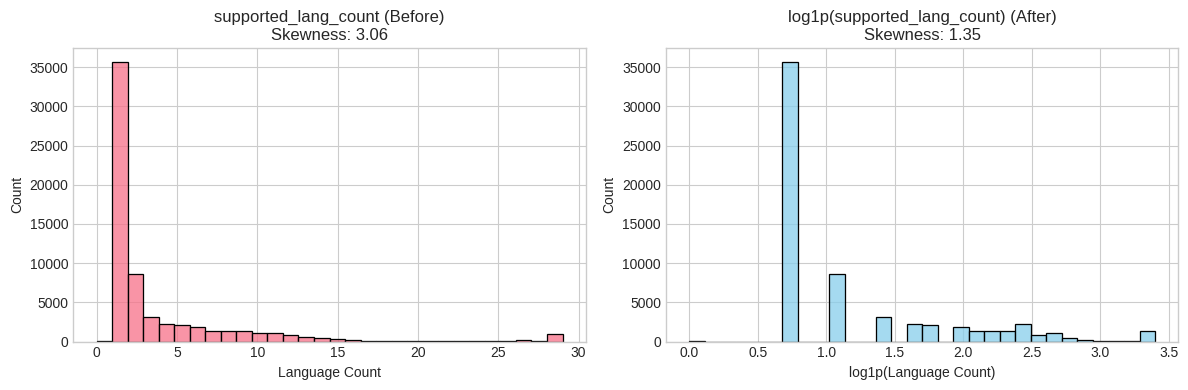

,Metric,Original,log_supported_lang_count
0,Min,0.00,0.00
1,Max,29.00,3.40
2,Mean,3.57,1.19
3,Median,1.00,0.69
4,Skewness,3.06,1.35


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Before log transform
sns.histplot(train_df['supported_lang_count'], bins=30, ax=axes[0], edgecolor='black')
axes[0].set_title(f"supported_lang_count (Before)\nSkewness: {train_df['supported_lang_count'].skew():.2f}")
axes[0].set_xlabel('Language Count')
axes[0].set_ylabel('Count')

train_df['log_supported_lang_count'] = np.log1p(train_df['supported_lang_count'])

# After log transform
sns.histplot(train_df['log_supported_lang_count'], bins=30, ax=axes[1], edgecolor='black', color='#87CEEB')
axes[1].set_title(f"log1p(supported_lang_count) (After)\nSkewness: {train_df['log_supported_lang_count'].skew():.2f}")
axes[1].set_xlabel('log1p(Language Count)')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

temp = pd.DataFrame({
    'Metric': ['Min', 'Max', 'Mean', 'Median', 'Skewness'],
    'Original': [train_df['supported_lang_count'].min(), train_df['supported_lang_count'].max(),
                 round(train_df['supported_lang_count'].mean(), 2), train_df['supported_lang_count'].median(),
                 round(train_df['supported_lang_count'].skew(), 2)],
    'log_supported_lang_count': [round(train_df['log_supported_lang_count'].min(), 2),
                                  round(train_df['log_supported_lang_count'].max(), 2),
                                  round(train_df['log_supported_lang_count'].mean(), 2),
                                  round(train_df['log_supported_lang_count'].median(), 2),
                                  round(train_df['log_supported_lang_count'].skew(), 2)]
})

train_df = train_df.drop(columns=['supported_lang_count'])
temp

The log1p transformation reduced skewness from 3.06 to 1.35. The distribution remains still right-skewed because most games support only 1 language. Original range was 0-29 languages. The transformation still could help by compressing the range.

#### audio_lang_count Transform

audio_lang_count is heavily right-skewed with many zeros: 57% of games have no audio localization. The has_audio feature already captures the binary distinction.

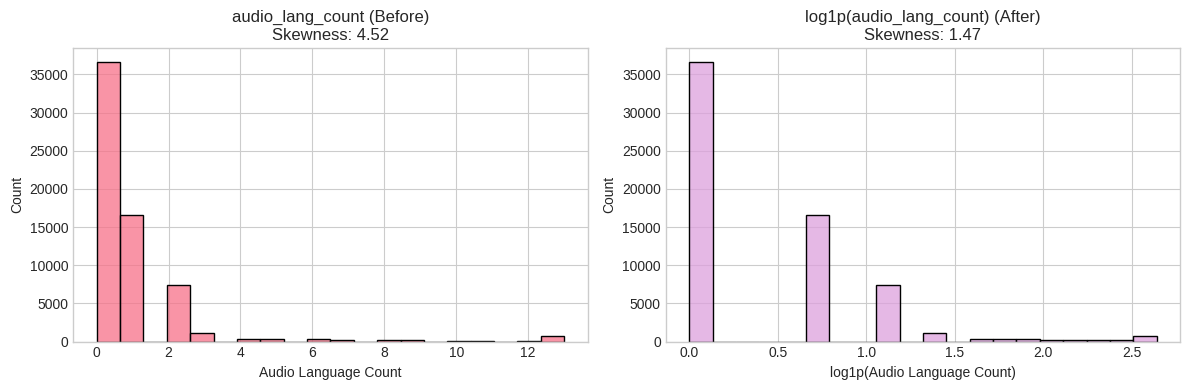

,Metric,Original,log_audio_lang_count
0,Min,0.00,0.00
1,Max,13.00,2.64
2,Mean,0.87,0.41
3,Median,0.00,0.00
4,Skewness,4.52,1.47


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Before log transform
sns.histplot(train_df['audio_lang_count'], bins=20, ax=axes[0], edgecolor='black')
axes[0].set_title(f"audio_lang_count (Before)\nSkewness: {train_df['audio_lang_count'].skew():.2f}")
axes[0].set_xlabel('Audio Language Count')
axes[0].set_ylabel('Count')

train_df['log_audio_lang_count'] = np.log1p(train_df['audio_lang_count'])

# After log transform
sns.histplot(train_df['log_audio_lang_count'], bins=20, ax=axes[1], edgecolor='black', color='#DDA0DD')
axes[1].set_title(f"log1p(audio_lang_count) (After)\nSkewness: {train_df['log_audio_lang_count'].skew():.2f}")
axes[1].set_xlabel('log1p(Audio Language Count)')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

temp = pd.DataFrame({
    'Metric': ['Min', 'Max', 'Mean', 'Median', 'Skewness'],
    'Original': [train_df['audio_lang_count'].min(), train_df['audio_lang_count'].max(),
                 round(train_df['audio_lang_count'].mean(), 2), train_df['audio_lang_count'].median(),
                 round(train_df['audio_lang_count'].skew(), 2)],
    'log_audio_lang_count': [round(train_df['log_audio_lang_count'].min(), 2),
                              round(train_df['log_audio_lang_count'].max(), 2),
                              round(train_df['log_audio_lang_count'].mean(), 2),
                              round(train_df['log_audio_lang_count'].median(), 2),
                              round(train_df['log_audio_lang_count'].skew(), 2)]
})
train_df = train_df.drop(columns=['audio_lang_count'])
temp

The log1p transformation reduced skewness from 4.52 to 1.47. The median remains 0 because most games have no audio localization, which is already captured by has_audio. For games with audio, the log transform compresses the range from 0-13 to 0-2.64, capturing the investment level in localization. We will use log_audio_lang_count alongside has_audio for modeling.

#### Categorical Features Inspection

Before encoding, let's inspect the actual unique values in each categorical column to understand the encoding complexity and identify any issues.

In [ ]:
# Inspecting categorical features before encoding

# Split multi-label columns and count unique values
genres_split = train_df['Genres'].str.split(',').explode().str.strip()
categories_split = train_df['Categories'].str.split(',').explode().str.strip()
tags_split = train_df['Tags'].str.split(',').explode().str.strip()

pd.DataFrame({
    'Feature': ['release_season', 'Genres', 'Categories', 'Tags'],
    'Type': ['Single-label', 'Multi-label', 'Multi-label', 'Multi-label'],
    'Unique Values': [
        train_df['release_season'].nunique(),
        len(genres_split[genres_split != ''].unique()),
        len(categories_split[categories_split != ''].unique()),
        len(tags_split[tags_split != ''].unique())
    ],
    'Missing/Empty': [
        train_df['release_season'].isna().sum(),
        (train_df['Genres'] == '').sum(),
        (train_df['Categories'] == '').sum(),
        (train_df['has_tags'] == 0).sum()
    ]
})

,Feature,Type,Unique Values,Missing/Empty
0,release_season,Single-label,4,0
1,Genres,Multi-label,33,0
2,Categories,Multi-label,40,0
3,Tags,Multi-label,447,8932


In [ ]:
top_genres = genres_split[genres_split != ''].value_counts().head(10).reset_index()
top_genres.columns = ['Genre', 'Count']

top_categories = categories_split[categories_split != ''].value_counts().head(10).reset_index()
top_categories.columns = ['Category', 'Count']

top_tags = tags_split[tags_split != ''].value_counts().head(10).reset_index()
top_tags.columns = ['Tag', 'Count']

display(top_genres)
display(top_categories)
display(top_tags)

,Genre,Count
0,Indie,46325
1,Casual,27486
2,Action,27107
3,Adventure,25651
4,Simulation,12998
5,Strategy,12329
6,RPG,11252
7,Early Access,7781
8,Sports,2995
9,Racing,2499


,Category,Count
0,Single-player,62292
1,Steam Achievements,31510
2,Steam Cloud,16603
3,Full controller support,13652
4,Multi-player,11198
5,Steam Trading Cards,8948
6,Partial Controller Support,8660
7,PvP,6750
8,Steam Leaderboards,5845
9,Co-op,5806


,Tag,Count
0,Indie,35189
1,Singleplayer,30313
2,Action,25164
3,Casual,24316
4,Adventure,23915
5,2D,16072
6,Strategy,11858
7,Simulation,11753
8,Puzzle,10583
9,RPG,10331


##### release_season One-Hot Encoding

Seasons are nominal categories with no ordinal relationship. Winter is not less than Spring. One-hot encoding creates 4 binary columns, allowing the model to learn arbitrary relationships between season and price without imposing false ordering assumptions. With only 4 categories, the dimensionality cost is negligible.

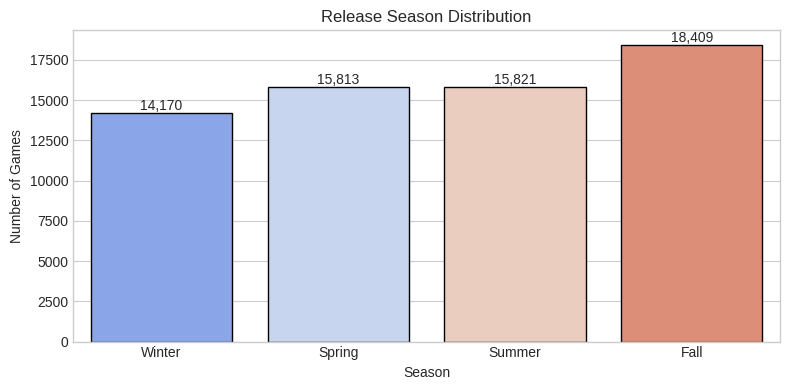

,Column,Count
0,season_Fall,18409
1,season_Spring,15813
2,season_Summer,15821
3,season_Winter,14170


In [ ]:
# 9c-1: release_season → One-Hot Encoding

# Visualize distribution before encoding
fig, ax = plt.subplots(figsize=(8, 4))
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
season_counts = train_df['release_season'].value_counts().reindex(season_order)
sns.barplot(x=season_counts.index, y=season_counts.values, ax=ax, palette='coolwarm', edgecolor='black')
ax.set_title('Release Season Distribution')
ax.set_xlabel('Season')
ax.set_ylabel('Number of Games')
for i, v in enumerate(season_counts.values):
    ax.text(i, v + 200, f'{v:,}', ha='center', fontsize=10)
plt.tight_layout()
plt.show()

# Create one-hot encoded columns
season_dummies = pd.get_dummies(train_df['release_season'], prefix='season')

# Add to dataframe and drop original
train_df = pd.concat([train_df, season_dummies], axis=1)
train_df = train_df.drop(columns=['release_season'])

# Summary
season_dummies.sum().reset_index().rename(columns={'index': 'Column', 0: 'Count'})

Created 4 binary season columns: season_Fall, season_Spring, season_Summer, season_Winter. Original release_season column dropped. Each game now has exactly one season flag set to 1.

##### Genres Multi-Hot Encoding

Genres are multi-label. A game can belong to multiple genres simultaneously (e.g."Action,RPG,Adventure"). Multi-hot encoding creates one binary column per unique genre. We exclude "Early Access" since it's already captured in the is_early_access feature created earlier.

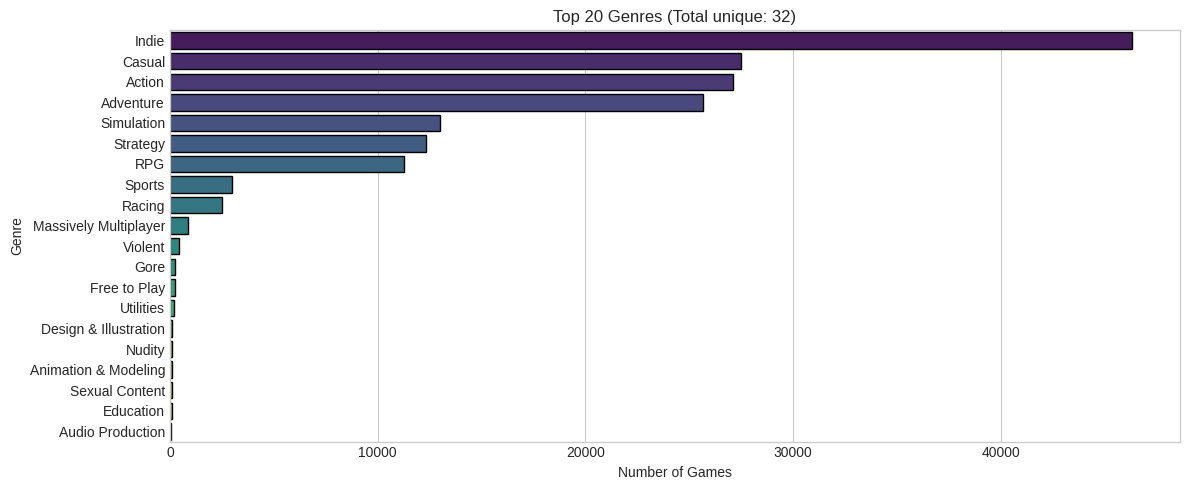

,Metric,Value
0,Unique genres encoded,32
1,Columns created,32


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

genres_split = train_df['Genres'].fillna('').str.split(',').apply(lambda x: [g.strip() for g in x if g.strip()])

all_genres = genres_split.explode()
genre_counts = all_genres[all_genres != ''].value_counts()
genres_to_encode = genre_counts[genre_counts.index != 'Early Access']

fig, ax = plt.subplots(figsize=(12, 5))
top_genres = genres_to_encode.head(20)
sns.barplot(x=top_genres.values, y=top_genres.index, ax=ax, palette='viridis', edgecolor='black')
ax.set_title(f'Top 20 Genres (Total unique: {len(genres_to_encode)})')
ax.set_xlabel('Number of Games')
ax.set_ylabel('Genre')
plt.tight_layout()
plt.show()


genres_filtered = genres_split.apply(lambda x: [g for g in x if g != 'Early Access'])

mlb_genres = MultiLabelBinarizer()
genres_encoded = mlb_genres.fit_transform(genres_filtered)
genres_df = pd.DataFrame(genres_encoded, columns=[f'genre_{g}' for g in mlb_genres.classes_], index=train_df.index)

train_df = pd.concat([train_df, genres_df], axis=1)
train_df = train_df.drop(columns=['Genres'])

pd.DataFrame({
    'Metric': ['Unique genres encoded', 'Columns created'],
    'Value': [len(mlb_genres.classes_), genres_df.shape[1]]
})

Created binary columns for each genre. "Early Access" was excluded from encoding since it's already captured in is_early_access feature. Indie is the dominant genre by far, followed by Action and Casual. The original Genres column was dropped.

##### Categories Multi-Hot Encoding

Steam Categories represent technical feature flags: Single-player, Multi-player, Steam Achievements, VR Support, etc. These binary properties could reflect development effort. Multi-hot encoding is semantically correct since categories are discrete feature flags.

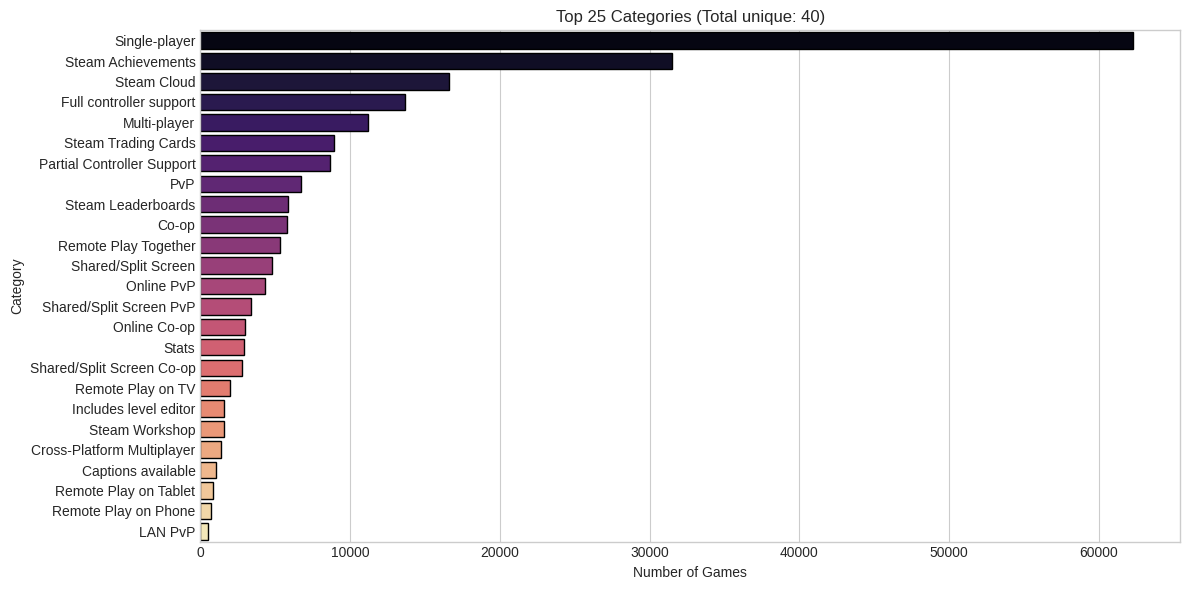

,Metric,Value
0,Unique categories encoded,40
1,Columns created,40


In [ ]:
categories_split = train_df['Categories'].fillna('').str.split(',').apply(lambda x: [c.strip() for c in x if c.strip()])

all_categories = categories_split.explode()
category_counts = all_categories[all_categories != ''].value_counts()

fig, ax = plt.subplots(figsize=(12, 6))
top_categories = category_counts.head(25)
sns.barplot(x=top_categories.values, y=top_categories.index, ax=ax, palette='magma', edgecolor='black')
ax.set_title(f'Top 25 Categories (Total unique: {len(category_counts)})')
ax.set_xlabel('Number of Games')
ax.set_ylabel('Category')
plt.tight_layout()
plt.show()

mlb_categories = MultiLabelBinarizer()
categories_encoded = mlb_categories.fit_transform(categories_split)
categories_df = pd.DataFrame(categories_encoded, columns=[f'cat_{c}' for c in mlb_categories.classes_], index=train_df.index)

train_df = pd.concat([train_df, categories_df], axis=1)
train_df = train_df.drop(columns=['Categories'])

pd.DataFrame({
    'Metric': ['Unique categories encoded', 'Columns created'],
    'Value': [len(mlb_categories.classes_), categories_df.shape[1]]
})

Created binary columns for each category. Single-player is the most common, followed by Steam Achievements and Steam Cloud. These features reflect development investment. Original Categories column dropped.

##### Tags Multi-Hot Encoding

Tags are community-assigned labels with 447 unique values and a long-tail distribution. To manage dimensionality while preserving signal, we keep only the top 100 most frequent tags. Less common tags are still captured by has_tags and tag_count. The choice of top 100 can be tuned as a hyperparameter during cross-validation.

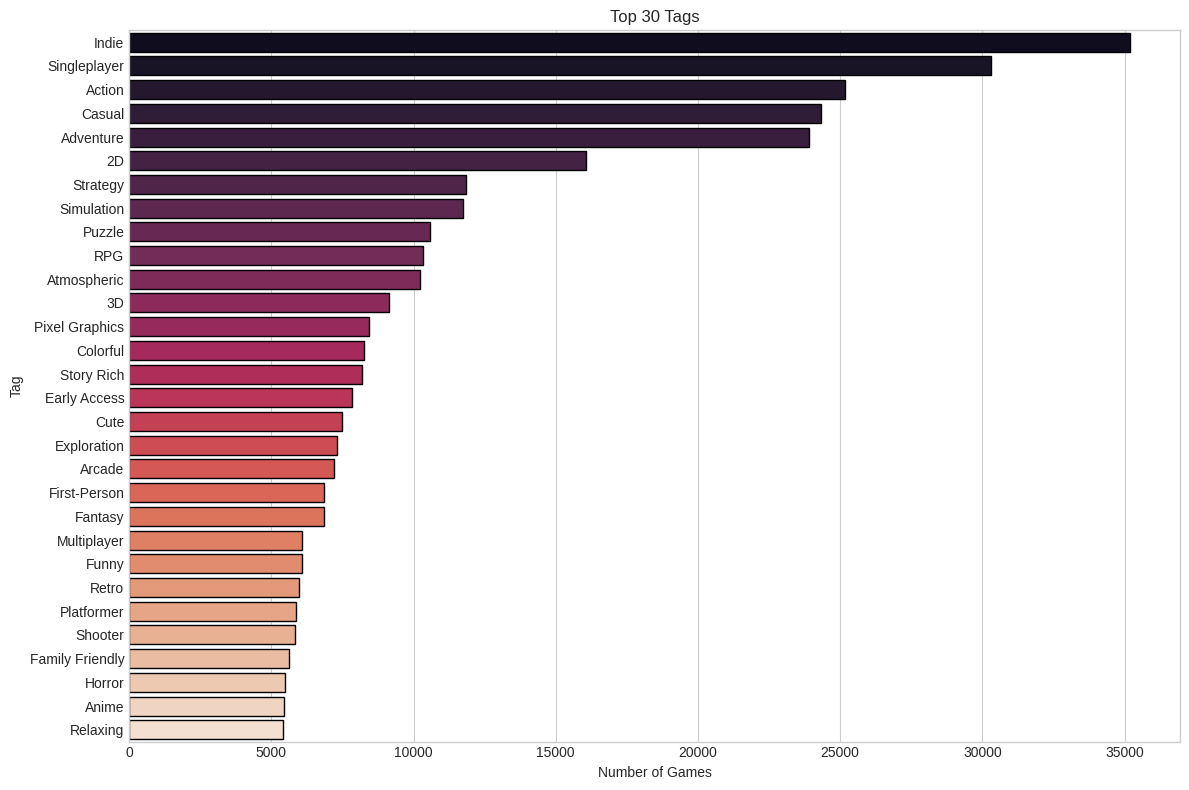

,Metric,Value
0,Total unique tags,447
1,Tags encoded (top N),100
2,Columns created,100


In [ ]:
tags_list = train_df['Tags'].fillna('').str.split(',').apply(lambda x: [t.strip() for t in x if t.strip()])

train_df['tag_count'] = tags_list.apply(len)

all_tags = tags_list.explode()
tag_frequency = all_tags[all_tags != ''].value_counts()

top_n = 100
top_tags = tag_frequency.head(top_n).index.tolist()

fig, ax = plt.subplots(figsize=(12, 8))
top_30 = tag_frequency.head(30)
sns.barplot(x=top_30.values, y=top_30.index, ax=ax, palette='rocket', edgecolor='black')
ax.set_title(f'Top 30 Tags')
ax.set_xlabel('Number of Games')
ax.set_ylabel('Tag')
plt.tight_layout()
plt.show()

tags_filtered = tags_list.apply(lambda x: [t for t in x if t in top_tags])

mlb_tags = MultiLabelBinarizer(classes=top_tags)
tags_encoded = mlb_tags.fit_transform(tags_filtered)
tag_columns = pd.DataFrame(tags_encoded, columns=[f'tag_{t}' for t in mlb_tags.classes_], index=train_df.index)

train_df = pd.concat([train_df, tag_columns], axis=1)
train_df = train_df.drop(columns=['Tags'])

pd.DataFrame({
    'Metric': ['Total unique tags', 'Tags encoded (top N)', 'Columns created'],
    'Value': [len(tag_frequency), top_n, tag_columns.shape[1]]
})

Encoded top 100 most frequent tags as binary columns. Indie, Singleplayer, and Action are the most common tags.

### 10. Scaling / Normalization

Scaling transforms numeric features to a comparable range. This matters for models that use distances or regularization. In linear models like Ridge, Lasso, and ElasticNet, if one feature has a much larger scale than another, it can dominate the optimization and get penalized differently. Scaling makes the regularization strength consistent across features and improves numerical stability.

Tree-based models split features using threshold rules that depend on ordering of values, not absolute scale. Rescaling a feature preserves the ordering, so trees can learn essentially the same decision structure. Scaling is not required for trees but does not hurt either.

In [ ]:
from sklearn.preprocessing import StandardScaler

features_to_scale = [
    'log_description_length',
    'log_supported_lang_count',
    'log_audio_lang_count',
    'release_year',
    'release_month',
    'release_day_of_week',
    'release_quarter',
    'tag_count',
    'Required age'
]

features_to_scale = [col for col in features_to_scale if col in train_df.columns]

before = train_df[features_to_scale].agg(['mean', 'std']).T
before.columns = ['Mean (Before)', 'Std (Before)']

scaler = StandardScaler()
train_df[features_to_scale] = scaler.fit_transform(train_df[features_to_scale])

after = train_df[features_to_scale].agg(['mean', 'std']).T
after['Mean (After)'] = after['mean'].abs().round(2)
after['Std (After)'] = after['std'].round(2)
after = after[['Mean (After)', 'Std (After)']]

comparison = pd.concat([before.round(2), after], axis=1)
comparison

,Mean (Before),Std (Before),Mean (After),Std (After)
log_description_length,5.12,0.72,0.0,1.0
log_supported_lang_count,1.19,0.71,0.0,1.0
log_audio_lang_count,0.41,0.56,0.0,1.0
release_year,2019.55,2.91,0.0,1.0
release_month,6.76,3.39,0.0,1.0
release_day_of_week,2.46,1.58,0.0,1.0
release_quarter,2.59,1.11,0.0,1.0
tag_count,11.23,7.60,0.0,1.0
Required age,0.35,2.37,0.0,1.0


Before scaling, features had very different ranges: release_year centered around 2020 with std 2.91, while log_audio_lang_count had mean 0.41 with std 0.56. After StandardScaler, all features now have mean 0 and std 1.

This standardization ensures that in linear models, no single feature dominates due to scale differences. For example, without scaling, release_year would have much larger coefficients than tag_count, making regularization penalties uneven. Now all features contribute equally to the model.

### 11. Feature Selection

Feature selection reduces dimensionality and removes redundant or uninformative features. With ~200 columns after encoding, we check for highly correlated features that add no new information, and near-zero variance features that provide no discriminative power. We perform this analysis on Train only.

In [ ]:
target_col = 'log_price'
feature_cols = [c for c in train_df.columns if c != target_col and c != 'Price']

pd.DataFrame({
    'Metric': ['Total features', 'Binary columns (0/1)', 'Multi-value columns', 'Target column'],
    'Value': [
        len(feature_cols),
        sum(train_df[feature_cols].nunique() == 2),
        sum(train_df[feature_cols].nunique() > 2),
        target_col
    ]
})

,Metric,Value
0,Total features,194
1,Binary columns (0/1),185
2,Multi-value columns,9
3,Target column,log_price


#### Correlation Analysis

For numeric features, we check for highly correlated pairs. If two features have high correlation, they carry nearly identical information and one can be dropped.

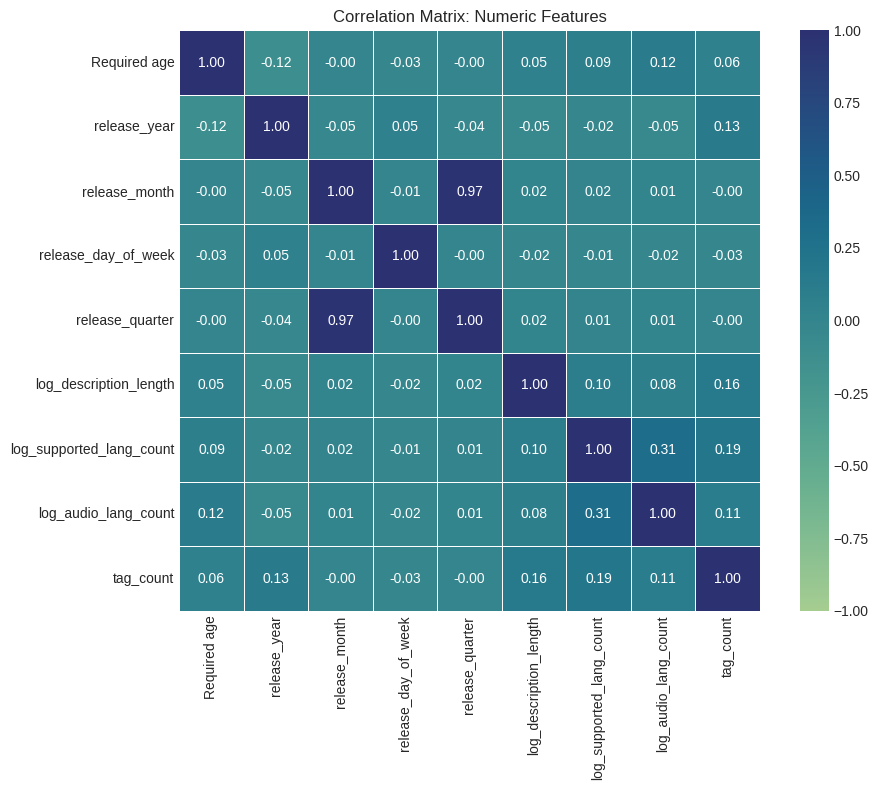

,Feature 1,Feature 2,Correlation
0,release_month,release_quarter,0.971


In [ ]:
numeric_features = [c for c in feature_cols if train_df[c].nunique() > 2]

corr_matrix = train_df[numeric_features].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='crest', center=0,
            square=True, linewidths=0.5, ax=ax, vmin=-1, vmax=1)
ax.set_title('Correlation Matrix: Numeric Features')
plt.tight_layout()
plt.show()

# Show high correlations (> 0.7) as table
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append({
                'Feature 1': corr_matrix.columns[i],
                'Feature 2': corr_matrix.columns[j],
                'Correlation': round(corr_matrix.iloc[i, j], 3)
            })

pd.DataFrame(high_corr_pairs).sort_values('Correlation', ascending=False, key=abs) if high_corr_pairs else pd.DataFrame({'Result': ['No pairs with |correlation| > 0.7']})

The correlation matrix shows release_month and release_quarter have correlation 0.97. This is happened because quarter is derived from month. We will drop release_quarter and keep release_month for more detailed information.

All other feature pairs have correlations below 0.7, indicating no redundant information.

In [ ]:
train_df = train_df.drop(columns=['release_quarter'])

#### Drop Near-Constant Columns

Two columns have almost identical values across all games and provide no discriminative power for price prediction

- Windows: Over 99% of Steam games support Windows. A feature that is almost always True cannot help distinguish higher-priced games from lower-priced ones.

- has_english_lang_support: Similarly, the vast majority of games on Steam support English. This column is nearly constant and adds no useful signal for the model.

Keeping these would only add noise and slight computational overhead without

In [ ]:
cols_to_drop = ['Windows', 'has_english_lang_support']
cols_to_drop = [c for c in cols_to_drop if c in train_df.columns]
train_df = train_df.drop(columns=cols_to_drop)

target_col = 'log_price'
feature_cols = [c for c in train_df.columns if c != target_col]

In [ ]:
target_col = 'log_price'
feature_cols = [c for c in train_df.columns if c != target_col]

binary_cols = [c for c in feature_cols if train_df[c].nunique() == 2]
numeric_cols = [c for c in feature_cols if train_df[c].nunique() > 2]

pd.DataFrame({
    'Metric': ['Total columns', 'Feature columns', 'Binary features', 'Numeric features', 'Target', 'Rows'],
    'Count': [len(train_df.columns), len(feature_cols), len(binary_cols), len(numeric_cols), target_col, len(train_df)]
})

,Metric,Count
0,Total columns,192
1,Feature columns,191
2,Binary features,183
3,Numeric features,8
4,Target,log_price
5,Rows,64213
